In [74]:
class DBSCAN_Viz:
    import numpy
    import pandas
    import typing
    
    def __init__(self, data:typing.Union[numpy.ndarray, pandas.DataFrame], is_pca:bool=True):
        self.data = data
        if is_pca:
            import numpy as np
            import pandas as pd
            if type(data) == np.ndarray:
                demension = data.shape[1]
            elif type(data) == pd.DataFrame:
                demension = len(data.columns)
            
            if demension > 2:
                print(
                    """데이터 컬럼 갯수가 3개 이상입니다. pca를 진행하여 컬럼 갯수를 2개로 맞춰줍니다.
                    만약 3차원 이상의 클러스터링을 진행한다면 is_pca=False로 설정해주세요. 3차원 이상이라면 시각화가 제대로 진행되지 않을 수 있습니다."""
                )
                self.data = self.pca(data)

    def pca(self, data:pandas.DataFrame) -> pandas.DataFrame:
        from sklearn.decomposition import PCA
        r"""클러스터링의 경우 보통 2차원 feature를 가지고 클러스터링을 진행합니다."""
        pca = PCA(n_components=2, random_state=42)  # 주성분 개수를 지정합니다. (여기서는 2차원으로 축소)
        data_pca = pca.fit_transform(data)
        
        return data_pca
    
    def hyper_parameter_tuning(self):
        r'''응집도와 분리도를 동시에 고려하는 실루엣 계수를 기준으로 가장 좋은 eps와 min_samples를 탐색합니다.'''
        import pandas as pd
        import seaborn as sns
        import matplotlib.pyplot as plt
        import numpy as np
        from itertools import product
        from sklearn.cluster import DBSCAN
        from sklearn.metrics import silhouette_score
        
        ###### 이 부분을 조정해주세요 #######

        eps_values = np.arange(2, 12.75, 0.25) # eps values to be investigated
        min_samples = np.arange(3, 10) # min_samples values to be investigated
        
        ###############################

        DBSCAN_params = list(product(eps_values, min_samples))
        
        no_of_clusters = []
        sil_score = []

        DBSCAN_parameters = []
        for p in DBSCAN_params:
            DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(self.data)
            n_clusters = len(np.unique(DBS_clustering.labels_))
            if (n_clusters) < 2:
                continue
            no_of_clusters.append(n_clusters)
            DBSCAN_parameters.append(p)
            sil_score.append(silhouette_score(self.data, DBS_clustering.labels_))
        
        tmp = pd.DataFrame.from_records(DBSCAN_parameters, columns =['Eps', 'Min_samples'])   
        tmp['No_of_clusters'] = no_of_clusters

        pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Eps', columns='Min_samples')
        fig, axes = plt.subplots(figsize=(15,10), nrows=1, ncols = 2)
        sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=axes[0])
        axes[0].set_title('Number of clusters')

        tmp['Sil_score'] = sil_score

        pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Eps', columns='Min_samples')
        axes[1].set_title('Sil_score')
        sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=axes[1])
        plt.show()
        
        maximum = tmp['Sil_score'].max()
        row = tmp['Sil_score'].idxmax()
        eps = tmp['Eps'][row]
        min_samples = tmp['Min_samples'][row]
        
        print(f'Global maximum Sil_score is {maximum} for eps={eps} and min_samples={min_samples}')
        
    
    def DBSCAN_visualize(self, eps:int=0.5, min_samples:int=4):
        import numpy
        import pandas as pd
        import seaborn as sns
        import matplotlib.pyplot as plt
        from sklearn.cluster import DBSCAN
        r'''hypterparameter tuning으로 구한 최적의 eps와 min_samples를 입력해주세요'''
        
        DBS_clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(self.data)
        if type(self.data) == numpy.ndarray:
            DBSCAN_clustered = pd.DataFrame(self.data)            
        else:
            columns = {c:idx for idx, c in enumerate(self.data.columns)}
            columns_r = {v:k for k, v in columns.items()}
            DBSCAN_clustered = self.data.copy().rename(columns=columns)
        DBSCAN_clustered['Cluster'] = DBS_clustering.labels_

        outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster'] == -1]

        fig2, axes = plt.subplots(figsize=(12,5))

        sns.scatterplot(data = DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1], x= 0, y = 1,
            hue='Cluster', ax=axes, palette='Set1', legend='full', s=45
        )

        if len(outliers) > 0:
            axes.scatter(outliers.iloc[:, 0], outliers.iloc[:, 1], s=5, label='outliers', c="k")
        axes.set_title('DBSCAN Clustering')
        axes.set_xlabel(f'{columns_r[0]}' if type(self.data) == pd.DataFrame else 'x')
        axes.set_ylabel(f'{columns_r[1]}' if type(self.data) == pd.DataFrame else 'y')
        axes.legend()

        plt.show()

(500, 2)

In [76]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=500, centers=4, random_state=42)

X.shape

(500, 2)

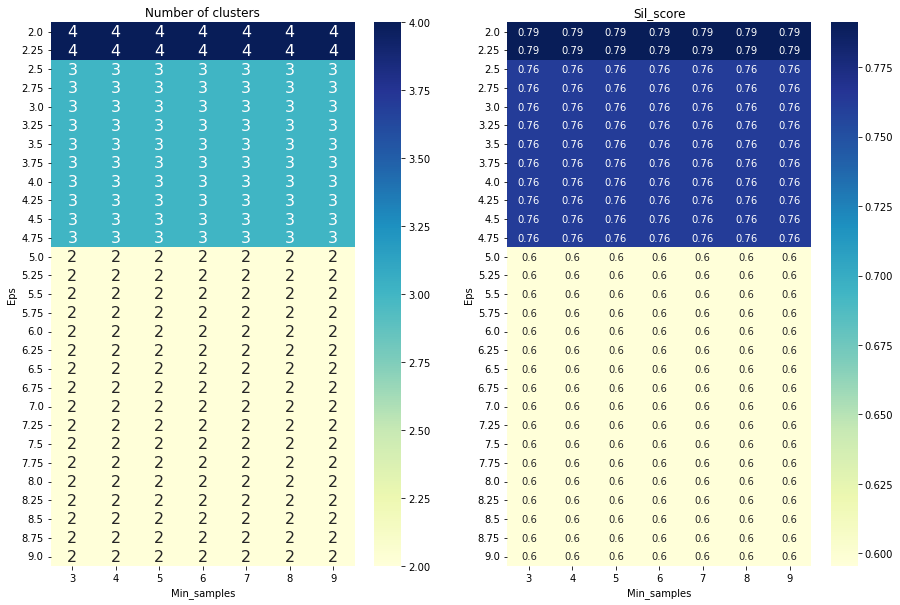

Global maximum Sil_score is 0.7911042588289479 for eps=2.0 and min_samples=3


In [75]:
dbscan = DBSCAN_Viz(X)
dbscan.hyper_parameter_tuning()

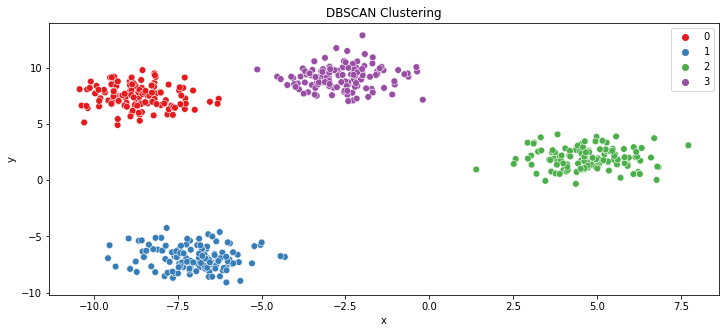

In [73]:
dbscan.DBSCAN_visualize(eps=2.0, min_samples=3)